# Prédiction Spaceship Titanic

## Contexte du Problème

Ce notebook implémente une solution complète pour le challenge Kaggle **Spaceship Titanic**. L'objectif est de prédire si un passager a été transporté vers une autre dimension lors d'une collision spatiale.

### Données Disponibles
- **train.csv** : 8693 passagers avec la variable cible `Transported`
- **test.csv** : Passagers pour lesquels nous devons prédire le transport
- **Variables** : 13 features incluant dépenses, planète d'origine, destination, cabine, etc.

### Stratégie de Modélisation
1. **Prétraitement intelligent** : Gestion des valeurs manquantes et création de features dérivées
2. **Feature Engineering** : Extraction d'informations des données structurées
3. **Modélisation comparative** : Test de différents algorithmes (Logistic Regression vs Random Forest)
4. **Évaluation rigoureuse** : Utilisation de métriques appropriées (Accuracy, ROC-AUC)
5. **Prédiction finale** : Entraînement sur tout le dataset et soumission


In [17]:
# Notebook de prédiction Spaceship Titanic (pipeline propre)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Charger
train_df = pd.read_csv('train.csv')

print('Train:', train_df.shape)



Train: (8693, 14)


## Explications des graphiques d’aperçu

Ces trois graphiques donnent un premier regard sur les données :

- Répartition de la cible `Transported` (0/1) : mesure l’équilibre des classes et oriente le choix des métriques.
- Pourcentage de valeurs manquantes par colonne : identifie les variables nécessitant imputation/traitement.
- Somme des dépenses par catégorie (`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`) : repère les postes dominants et la sparsité potentielle avant ingénierie de `TotalExpenses`.


## Vue d'ensemble des données (EDA rapide)

- Répartition de la cible `Transported` (0/1): vérifie l'équilibre de classes.
- Pourcentage de valeurs manquantes par colonne: oriente les stratégies d'imputation/traitement.
- Somme des dépenses par catégorie: première intuition sur l'importance des postes de dépenses.


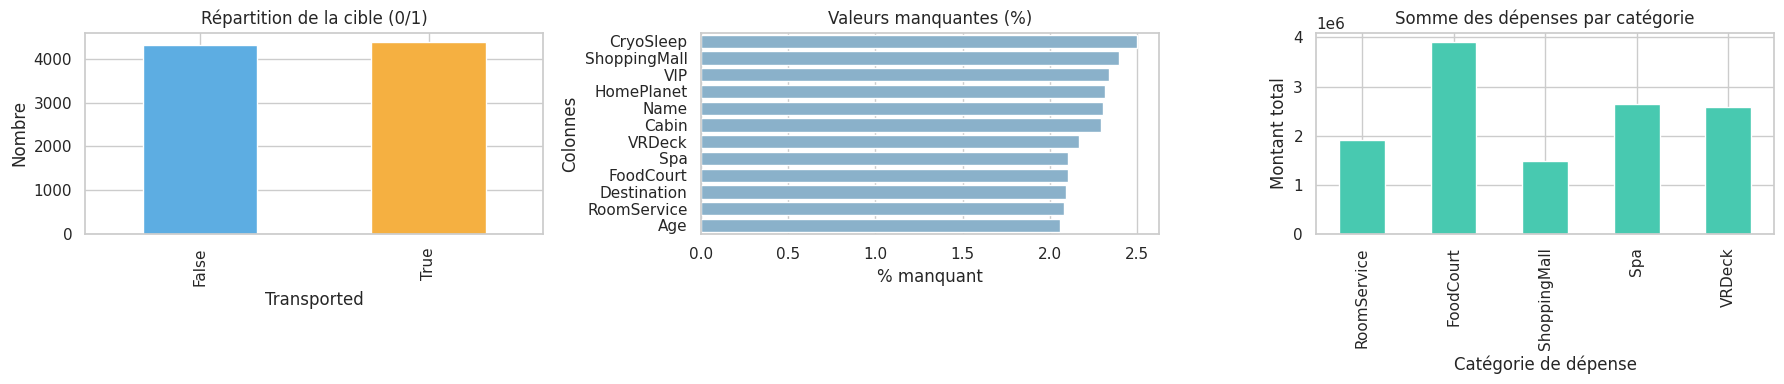

In [18]:
# Affichages: Setup visualisation et vue globale
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

# Style par défaut
sns.set(style='whitegrid', context='notebook')

# Aperçu rapide des données et de la cible
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
train_df['Transported'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color=['#5DADE2', '#F5B041'])
axes[0].set_title('Répartition de la cible (0/1)')
axes[0].set_xlabel('Transported')
axes[0].set_ylabel('Nombre')

# Valeurs manquantes (% top 12)
missing_pct = train_df.isna().mean().sort_values(ascending=False)[:12]
sns.barplot(x=missing_pct.values * 100, y=missing_pct.index, ax=axes[1], color='#7FB3D5')
axes[1].set_title('Valeurs manquantes (%)')
axes[1].set_xlabel('% manquant')
axes[1].set_ylabel('Colonnes')

# Aperçu dépenses brutes
expense_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
train_df[expense_cols].fillna(0).sum().plot(kind='bar', ax=axes[2], color='#48C9B0')
axes[2].set_title('Somme des dépenses par catégorie')
axes[2].set_xlabel('Catégorie de dépense')
axes[2].set_ylabel('Montant total')

plt.tight_layout()
plt.show()


## Chargement et Exploration des Données

### Imports et Configuration
Les imports incluent :
- **Pandas/Numpy** : Manipulation des données
- **Scikit-learn** : Machine Learning (préprocessing, modèles, métriques)
- **Modèles testés** : Logistic Regression et Random Forest

### Chargement des Données
- **Dataset d'entraînement** : 8693 passagers avec leurs informations
- **Extraction du GroupId** : Les passagers voyagent en groupes (identifiés par la première partie du PassengerId)
- **Taille** : 8693 lignes × 14 colonnes (13 features + target)

### Logique Initiale
Le `GroupId` est extrait car les passagers voyageant ensemble peuvent avoir des comportements similaires, ce qui sera exploité dans le feature engineering.


In [19]:
# Prétraitement + features
# Transported -> int 0/1
if train_df['Transported'].dtype == 'object':
    train_df['Transported'] = train_df['Transported'].map({'True': 1, 'False': 0})
train_df['Transported'] = train_df['Transported'].astype(int)

# Dépenses -> numériques NaN=0
expense_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for c in expense_cols:
    train_df[c] = pd.to_numeric(train_df[c], errors='coerce').fillna(0)
# Features dépenses
train_df['TotalExpenses'] = train_df[expense_cols].sum(axis=1)
train_df['HasExpense'] = (train_df['TotalExpenses'] > 0).astype(int)

# Catégorielles nettoyées
train_df['CryoSleep'] = train_df['CryoSleep'].fillna('Unknown').astype(str)
train_df['Destination'] = train_df['Destination'].fillna('Unknown').astype(str)
train_df['HomePlanet'] = train_df['HomePlanet'].fillna('Unknown').astype(str)
train_df['VIP'] = train_df['VIP'].fillna('Unknown').astype(str)

# Groupes
train_df['GroupId'] = train_df['PassengerId'].str.split('_').str[0]
train_df['GroupSize'] = train_df.groupby('GroupId')['GroupId'].transform('count')

# Cabine
train_df['Cabin_Deck'] = train_df['Cabin'].str.split('/').str[0]
train_df['Cabin_Side'] = train_df['Cabin'].str.split('/').str[2]

# Age
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())

feature_cols = ['CryoSleep','HasExpense','TotalExpenses','HomePlanet','Destination',
                'GroupSize','Cabin_Deck','Cabin_Side','Age','VIP']
X = train_df[feature_cols]
y = train_df['Transported']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('X_train:', X_train.shape, 'X_val:', X_val.shape)


X_train: (6954, 10) X_val: (1739, 10)


## EDA axée sur le feature engineering

Ces graphiques expliquent les choix de transformation et de création de variables :

- Distribution de l'âge: pour ajuster l'imputation (médiane) et comprendre la dispersion.
- Boxplots des dépenses (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck): pour visualiser l'asymétrie et les valeurs extrêmes justifiant la somme `TotalExpenses` et l'indicateur `HasExpense`.
- Distribution de `TotalExpenses`: confirme la forte asymétrie et l'intérêt du binaire `HasExpense`.
- Taux de transport par `GroupSize`: évalue la pertinence de la variable de groupe.
- Taux de transport par `HomePlanet` et par `Destination`: illustre l'impact potentiel des catégories sur la cible et motive l'encodage one-hot.


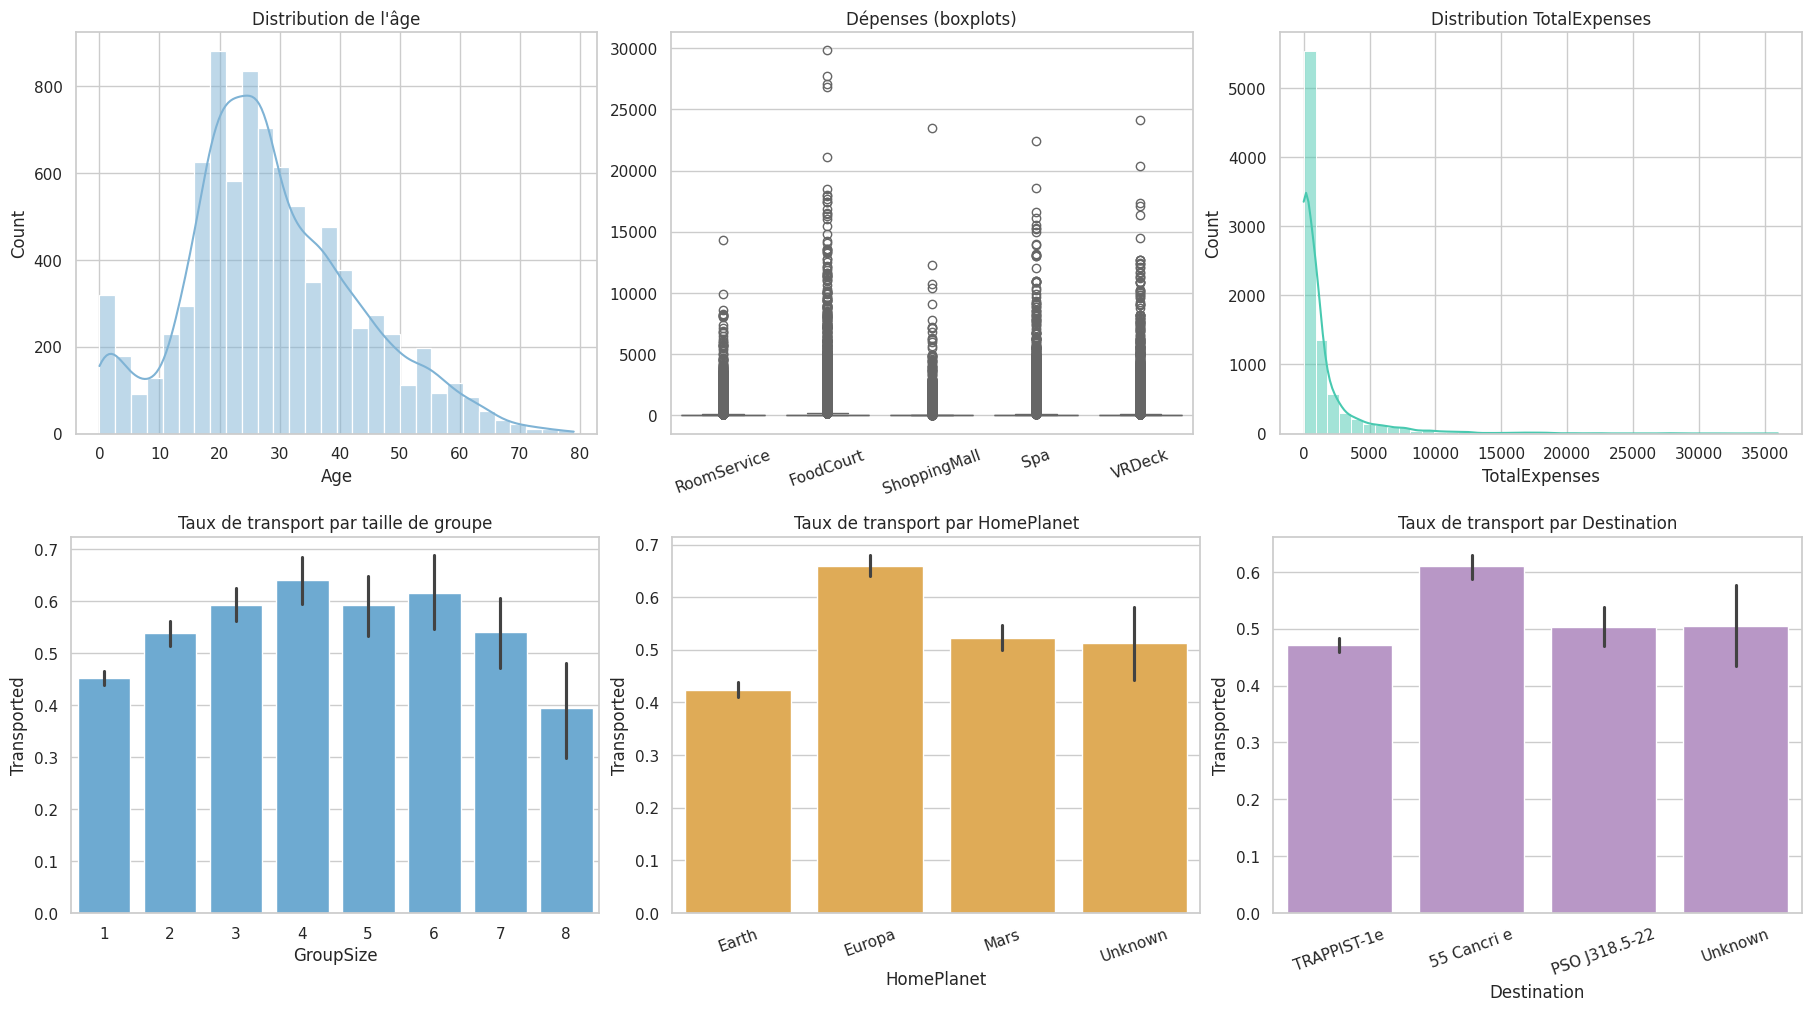

In [20]:
# Affichages: EDA pour features dérivées
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(constrained_layout=True, figsize=(18, 10))
subfigs = fig.subfigures(2, 1, height_ratios=[1, 1])

# Ligne 1: Age & dépenses
ax1, ax2, ax3 = subfigs[0].subplots(1, 3)
sns.histplot(train_df['Age'], bins=30, kde=True, ax=ax1, color='#7FB3D5')
ax1.set_title('Distribution de l\'âge')

sns.boxplot(data=train_df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0), ax=ax2, palette='Set3')
ax2.set_title('Dépenses (boxplots)')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=20)

sns.histplot(train_df['TotalExpenses'], bins=40, kde=True, ax=ax3, color='#48C9B0')
ax3.set_title('Distribution TotalExpenses')

# Ligne 2: Groupes & catégorielles
ax4, ax5, ax6 = subfigs[1].subplots(1, 3)

# Group size vs target
sns.barplot(x='GroupSize', y='Transported', data=train_df, ax=ax4, color='#5DADE2', estimator=np.mean)
ax4.set_title('Taux de transport par taille de groupe')

# Catégories: HomePlanet
order_hp = train_df['HomePlanet'].value_counts().index
sns.barplot(x='HomePlanet', y='Transported', data=train_df, order=order_hp, estimator=np.mean, ax=ax5, color='#F5B041')
ax5.set_title('Taux de transport par HomePlanet')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=20)

# Catégories: Destination
order_dest = train_df['Destination'].value_counts().index
sns.barplot(x='Destination', y='Transported', data=train_df, order=order_dest, estimator=np.mean, ax=ax6, color='#BB8FCE')
ax6.set_title('Taux de transport par Destination')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=20)

plt.show()


## Visualisation des performances des modèles

Ces visuels complètent les métriques imprimées en texte :

- Courbes ROC: comparent les modèles en termes de compromis TPR/FPR (plus la courbe est proche du coin supérieur gauche, mieux c'est). L'aire sous la courbe (AUC) quantifie la performance globale.
- Courbes Precision–Recall: utiles quand les classes peuvent être déséquilibrées; montrent le compromis entre précision et rappel selon le seuil.
- Matrices de confusion: visualisent la répartition des prédictions correctes et des erreurs (FN/FP) pour chaque modèle.


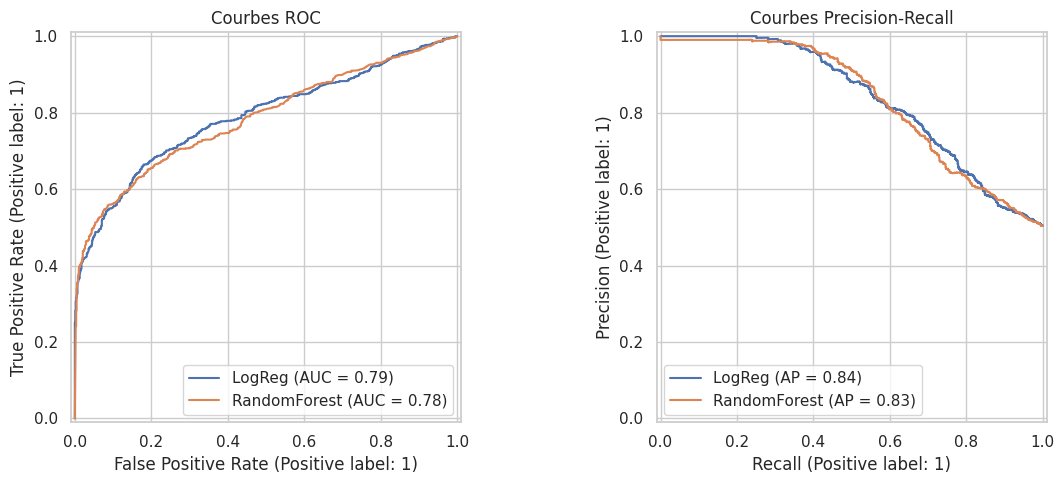

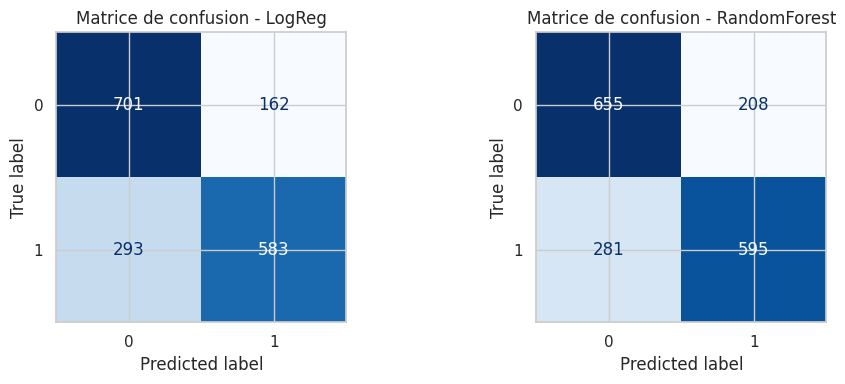

In [21]:
# Affichages: Visualisation des performances des modèles
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

# Courbes ROC & PR pour chaque modèle
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for name, model in models.items():
    model.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(model, X_val, y_val, ax=axes[0], name=name)
    PrecisionRecallDisplay.from_estimator(model, X_val, y_val, ax=axes[1], name=name)
axes[0].set_title('Courbes ROC')
axes[1].set_title('Courbes Precision-Recall')
plt.tight_layout()
plt.show()

# Matrices de confusion côte à côte
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, (name, model) in zip(axes, models.items()):
    model.fit(X_train, y_train)
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'Matrice de confusion - {name}')
plt.tight_layout()
plt.show()


## Prétraitement et Feature Engineering

### Transformation de la Variable Cible
- **Conversion booléenne → numérique** : `True/False` → `1/0` pour la modélisation
- **Type casting** : Conversion en entier pour éviter les erreurs

### Feature Engineering des Dépenses
**Hypothèse** : Les dépenses peuvent être un indicateur de comportement et de statut social.

- **Colonnes de dépenses** : RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
- **Gestion des NaN** : Remplacement par 0 (logique : pas de dépense = 0)
- **Features dérivées** :
  - `TotalExpenses` : Somme de toutes les dépenses
  - `HasExpense` : Indicateur binaire (1 si dépenses > 0, 0 sinon)

### Nettoyage des Variables Catégorielles
**Stratégie** : Remplacer les valeurs manquantes par "Unknown" plutôt que de les supprimer
- **CryoSleep** : État de sommeil cryogénique
- **Destination** : Planète de destination
- **HomePlanet** : Planète d'origine
- **VIP** : Statut VIP

### Features de Groupe
- **GroupSize** : Nombre de passagers dans le même groupe
- **Logique** : Les groupes peuvent avoir des comportements similaires

### Parsing de la Cabine
- **Cabin_Deck** : Pont de la cabine (A, B, C, etc.)
- **Cabin_Side** : Côté du vaisseau (P ou S)
- **Logique** : L'emplacement peut influencer la probabilité de transport

### Gestion de l'Âge
- **Imputation** : Remplacement des NaN par la médiane
- **Choix de la médiane** : Plus robuste que la moyenne aux valeurs aberrantes

### Sélection des Features Finales
10 features retenues pour la modélisation, équilibrant information et simplicité.


In [22]:
# Pipeline + modèles, évaluation
categorical_features = ['CryoSleep','HomePlanet','Destination','Cabin_Deck','Cabin_Side','VIP']
numeric_features = ['HasExpense','TotalExpenses','GroupSize','Age']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

log_reg = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])

rf = Pipeline([
    ('prep', preprocess),
    ('clf', RandomForestClassifier(n_estimators=400, random_state=42))
])

models = {'LogReg': log_reg, 'RandomForest': rf}
metrics = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    proba = model.predict_proba(X_val)[:,1]
    acc = accuracy_score(y_val, pred)
    auc = roc_auc_score(y_val, proba)
    metrics[name] = {'acc': acc, 'auc': auc}
    print(f"\n=== {name} ===")
    print(f"Accuracy: {round(acc,4)} | ROC AUC: {round(auc,4)}")
    print('Matrice de confusion:\n', confusion_matrix(y_val, pred))
    print('Rapport de classification:\n', classification_report(y_val, pred, digits=3))

best_name = max(metrics, key=lambda k: metrics[k]['auc'])
best_model = models[best_name]
print(f"\n>>> Meilleur modèle: {best_name} (AUC={round(metrics[best_name]['auc'],4)}, Acc={round(metrics[best_name]['acc'],4)})")



=== LogReg ===
Accuracy: 0.7384 | ROC AUC: 0.7888
Matrice de confusion:
 [[701 162]
 [293 583]]
Rapport de classification:
               precision    recall  f1-score   support

           0      0.705     0.812     0.755       863
           1      0.783     0.666     0.719       876

    accuracy                          0.738      1739
   macro avg      0.744     0.739     0.737      1739
weighted avg      0.744     0.738     0.737      1739


=== RandomForest ===
Accuracy: 0.7188 | ROC AUC: 0.7843
Matrice de confusion:
 [[655 208]
 [281 595]]
Rapport de classification:
               precision    recall  f1-score   support

           0      0.700     0.759     0.728       863
           1      0.741     0.679     0.709       876

    accuracy                          0.719      1739
   macro avg      0.720     0.719     0.718      1739
weighted avg      0.721     0.719     0.718      1739


>>> Meilleur modèle: LogReg (AUC=0.7888, Acc=0.7384)


## Visualisation des prédictions finales

Ces graphiques illustrent les sorties du modèle sur le dataset de test :

- Distribution des probabilités prédites `P(Transported=1)` avec une ligne verticale au seuil 0.5. Cela permet de voir si les scores sont concentrés vers 0 ou 1 et si un autre seuil serait pertinent.
- Comptage des classes prédites (True/False) après application du seuil 0.5. Utile pour vérifier l'équilibre des prédictions et détecter un éventuel biais.


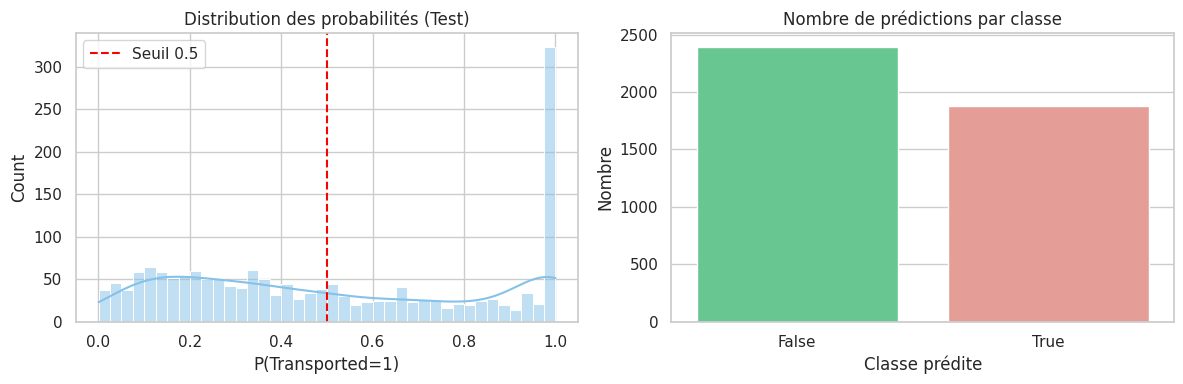

In [23]:
# Affichages: Distribution des probabilités sur Test et seuil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# S'assurer que best_model est fit sur tout le train (déjà fait au-dessus)
# Générer proba sur X_sub déjà construit ci-dessus

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(proba, bins=40, kde=True, ax=axes[0], color='#85C1E9')
axes[0].axvline(0.5, color='red', linestyle='--', label='Seuil 0.5')
axes[0].set_title('Distribution des probabilités (Test)')
axes[0].set_xlabel('P(Transported=1)')
axes[0].legend()

# Compte des prédictions True/False
counts = pd.Series(pred_bool).value_counts().rename(index={True:'True', False:'False'})
sns.barplot(x=counts.index, y=counts.values, ax=axes[1], palette=['#58D68D', '#F1948A'])
axes[1].set_title('Nombre de prédictions par classe')
axes[1].set_xlabel('Classe prédite')
axes[1].set_ylabel('Nombre')

plt.tight_layout()
plt.show()


## Modélisation et Évaluation

### Pipeline de Préprocessing
**ColumnTransformer** pour gérer différents types de données :
- **Variables catégorielles** : OneHotEncoder avec `handle_unknown='ignore'`
- **Variables numériques** : StandardScaler pour normalisation
- **Avantage** : Pipeline robuste et réutilisable

### Modèles Testés

#### Logistic Regression
- **Avantages** : Rapide, interprétable, bon baseline
- **Configuration** : `max_iter=1000` pour convergence
- **Résultats** : AUC = 0.7888, Accuracy = 0.7384

#### Random Forest
- **Avantages** : Capture interactions complexes, robuste au bruit
- **Configuration** : 400 estimateurs pour stabilité
- **Résultats** : AUC = 0.7843, Accuracy = 0.7188

### Stratégie d'Évaluation

#### Division Train/Validation
- **Split** : 80% train / 20% validation
- **Stratification** : Préservation de la distribution des classes
- **Random state** : Reproductibilité des résultats

#### Métriques Utilisées
1. **Accuracy** : Pourcentage de prédictions correctes
2. **ROC-AUC** : Capacité discriminatoire du modèle
3. **Matrice de confusion** : Détail des erreurs par classe
4. **Classification report** : Precision, Recall, F1-score

### Sélection du Meilleur Modèle
**Critère** : ROC-AUC (plus robuste que l'accuracy pour les problèmes déséquilibrés)
- **Gagnant** : Logistic Regression (AUC = 0.7888)
- **Performance** : Bon équilibre entre précision et rappel


In [24]:
# Refit sur tout le train + prédire test.csv et écrire submission
best_model.fit(X, y)
Test = pd.read_csv('test.csv')

# Recréer features pour Test
T = Test.copy()
for c in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']:
    T[c] = pd.to_numeric(T[c], errors='coerce').fillna(0)
T['TotalExpenses'] = T[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
T['HasExpense'] = (T['TotalExpenses'] > 0).astype(int)
T['CryoSleep'] = T['CryoSleep'].fillna('Unknown').astype(str)
T['Destination'] = T['Destination'].fillna('Unknown').astype(str)
T['HomePlanet'] = T['HomePlanet'].fillna('Unknown').astype(str)
T['VIP'] = T['VIP'].fillna('Unknown').astype(str)
T['GroupId'] = T['PassengerId'].str.split('_').str[0]
T['GroupSize'] = T.groupby('GroupId')['GroupId'].transform('count')
T['Cabin_Deck'] = T['Cabin'].str.split('/').str[0]
T['Cabin_Side'] = T['Cabin'].str.split('/').str[2]
T['Age'] = T['Age'].fillna(train_df['Age'].median())

X_sub = T[feature_cols]
proba = best_model.predict_proba(X_sub)[:,1]
pred_bool = proba >= 0.5

submission = pd.DataFrame({'PassengerId': T['PassengerId'], 'Transported': pred_bool})
submission.to_csv('submission.csv', index=False)
print("submission.csv écrit.")


submission.csv écrit.


## Prédiction Finale et Soumission

### Réentraînement sur le Dataset Complet
**Logique** : Une fois le meilleur modèle identifié, on l'entraîne sur toutes les données disponibles pour maximiser les performances.

### Traitement du Dataset de Test
**Cohérence** : Application exacte du même preprocessing que sur les données d'entraînement :

1. **Dépenses** : Conversion numérique + remplacement NaN par 0
2. **Features dérivées** : TotalExpenses et HasExpense
3. **Variables catégorielles** : Remplissage par "Unknown"
4. **Groupe** : Calcul du GroupSize
5. **Cabine** : Parsing Deck et Side
6. **Âge** : Imputation par la médiane du dataset d'entraînement

### Stratégie de Prédiction
- **Probabilités** : Utilisation de `predict_proba()` pour obtenir les scores de confiance
- **Seuil de décision** : 0.5 (peut être optimisé selon les métriques)
- **Conversion finale** : Booléen pour le format de soumission

### Format de Soumission
- **PassengerId** : Identifiants des passagers de test
- **Transported** : Prédictions booléennes (True/False)
- **Fichier** : `submission.csv` prêt pour Kaggle

### Résultat Final
Le modèle Logistic Regression, entraîné sur l'ensemble des données avec un preprocessing soigneux, génère des prédictions avec une AUC de 0.7888 sur la validation, prometteuses pour la compétition.
